In [1]:
import cv2
import tensorflow as tf
import os
import time
import uuid
import labelme
import albumentations
import json
import numpy as np
import matplotlib.pylab as plt

# Collect data using OpenCV

In [2]:
IMAGE_PATH = os.path.join('dataset', 'images')
num_of_img = 30

In [9]:
cap = cv2.VideoCapture(0)
for imgnum in range(num_of_img):
    print(f'Collecting Image {imgnum}')
    ret, frame = cap.read()
    imgname = os.path.join(IMAGE_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Annotate Images with Labelme

In [10]:
!labelme

2024-03-13 14:38:48,745 [INFO   ] __init__:get_config:67- Loading config file from: /Users/taimourabdulkarim/.labelmerc


# Review Dataset and Build Image Loading Function

In [3]:
images = tf.data.Dataset.list_files('dataset/images/*.jpg')

2024-03-13 15:10:22.793519: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-13 15:10:22.793548: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-13 15:10:22.793552: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-13 15:10:22.793822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-13 15:10:22.793844: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: dataset/images/*.jpg'

In [ ]:
images.as_numpy_iterator().next()

b'dataset/images/9a214d28-e11b-11ee-8085-0e47976fb6f8.jpg'

In [ ]:
def load_img(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_img)

In [ ]:
images.as_numpy_iterator().next()

array([[[212, 236, 238],
        [212, 236, 238],
        [212, 233, 238],
        ...,
        [156, 136, 101],
        [162, 142, 107],
        [170, 150, 115]],

       [[211, 235, 237],
        [213, 237, 239],
        [214, 235, 240],
        ...,
        [160, 140, 105],
        [158, 138, 103],
        [167, 147, 112]],

       [[214, 235, 238],
        [216, 237, 240],
        [217, 238, 243],
        ...,
        [158, 138, 103],
        [152, 132,  97],
        [153, 133,  98]],

       ...,

       [[170, 167, 150],
        [163, 160, 143],
        [162, 161, 143],
        ...,
        [ 55,  61,  57],
        [ 60,  66,  62],
        [ 68,  74,  70]],

       [[159, 156, 141],
        [153, 150, 135],
        [156, 153, 136],
        ...,
        [ 53,  59,  55],
        [ 64,  69,  65],
        [ 39,  44,  40]],

       [[165, 162, 147],
        [163, 160, 145],
        [152, 149, 132],
        ...,
        [ 50,  56,  52],
        [ 35,  40,  36],
        [ 46,  51,  47]]

In [ ]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

# Raw Images

In [ ]:
img_gen = images.batch(4).as_numpy_iterator()

In [4]:
plot_images = img_gen.next()

NameError: name 'img_gen' is not defined

NameError: name 'plot_images' is not defined

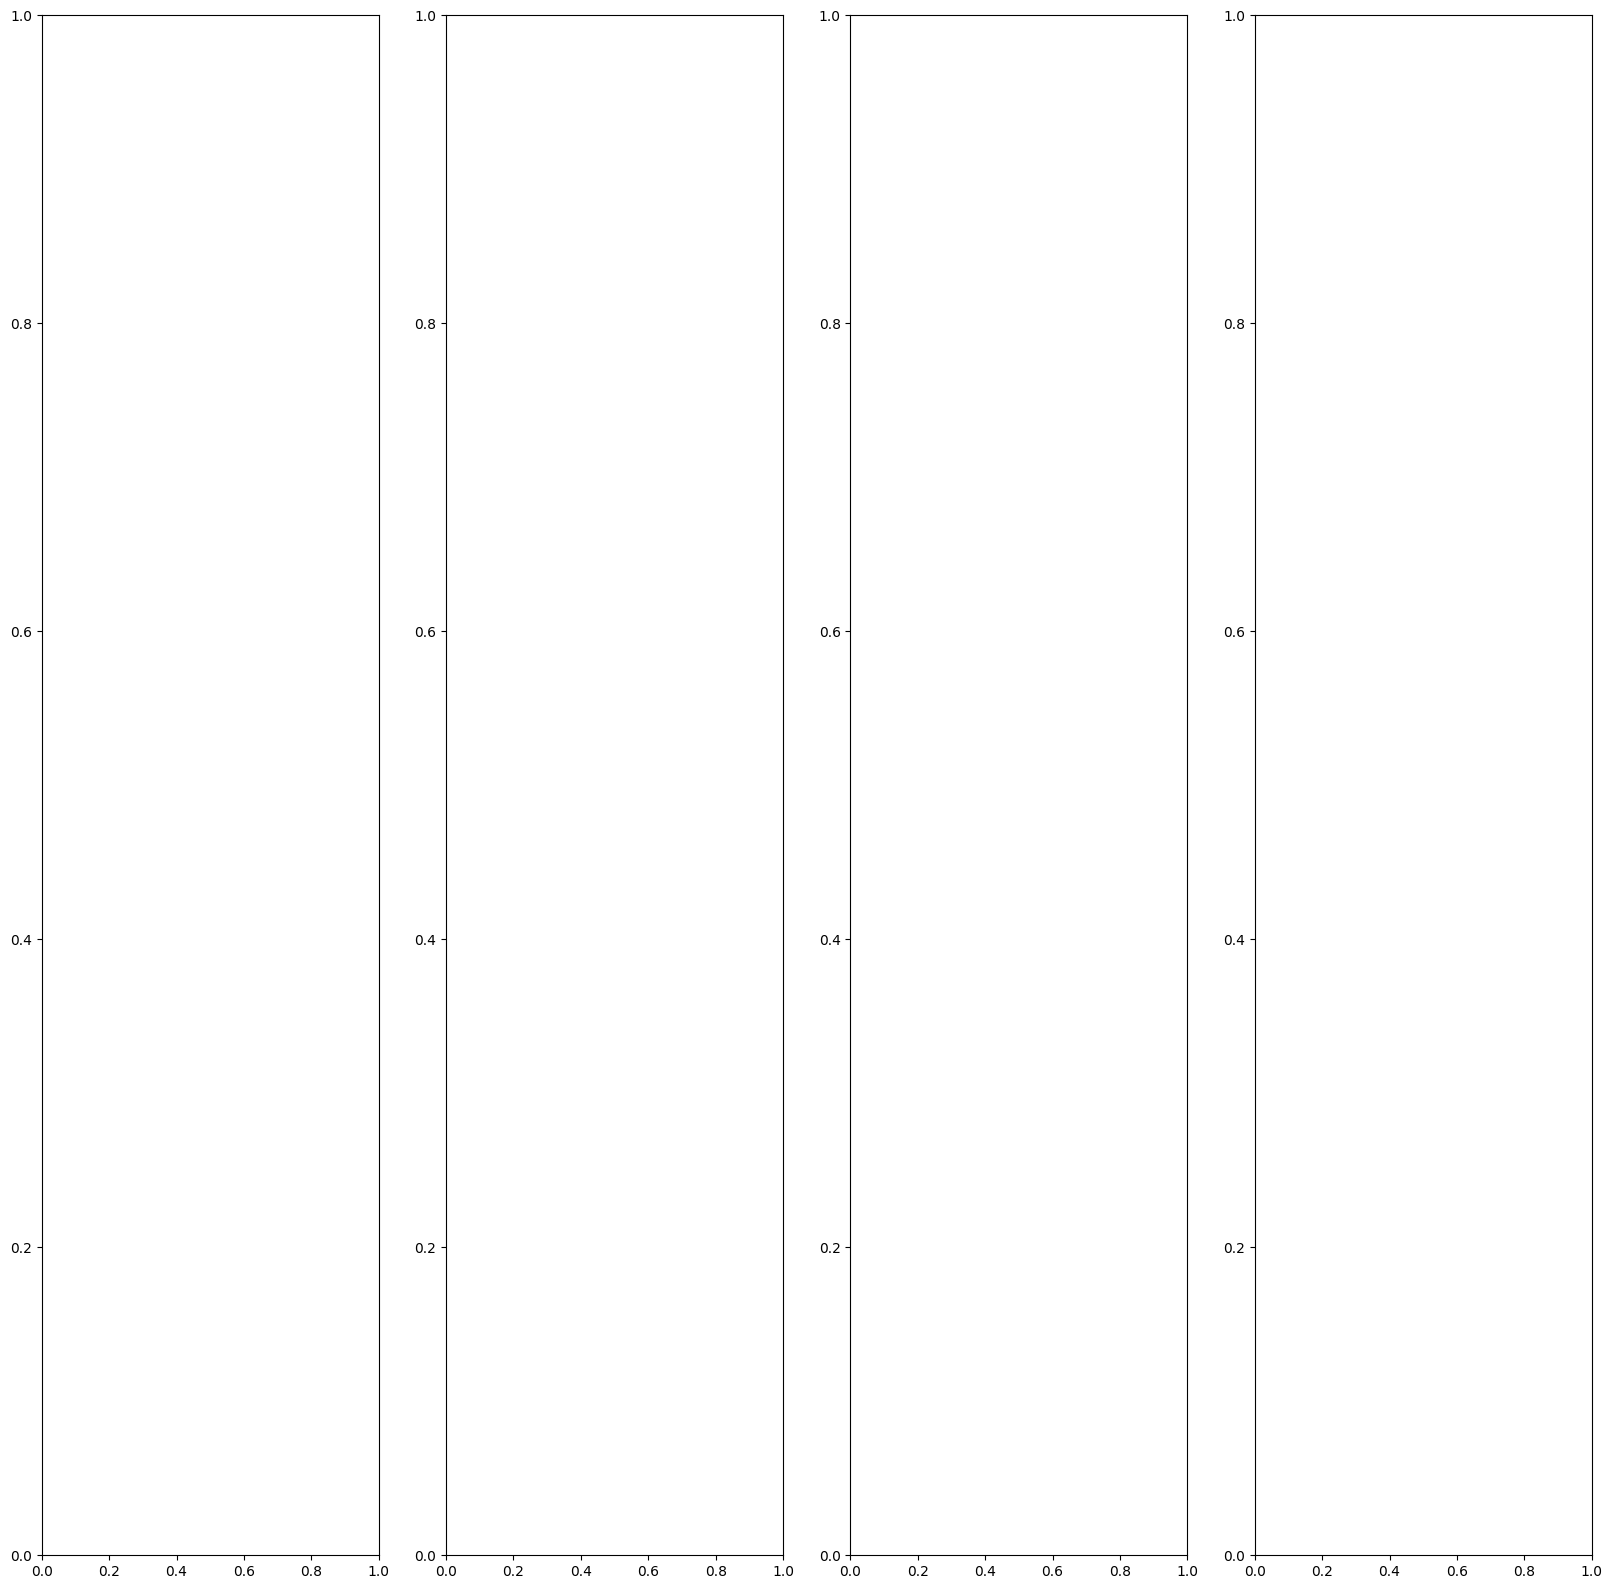

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(plot_images):
    ax[idx].imshow(img)
plt.show()

# Partition Unaugmented Data

Manually move images to train test and val folders

In [6]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('dataset', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('dataset', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('dataset', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

# Apply Image Augmentation